# REGRESSION MODEL:
Due to nature of this process (creating a predictive model), involving coming back and forth trial and error while cleaning data and testing differet hyperparameters setup. We decided to:

- Move all our helper functions to a separated file, so we can reach them from every file while keeping our files cleaner.
- Have 2 code files to get our final model:
    - File `reg_data_proccessing.ipynb`:<br>
        &emsp;To read and clean the data and save it to sql database in ``./database/models.db`` file.<br>
        &emsp;To test cleanliness of data, we'll use a random forest model.
    - File `reg_model_selection.ipynb` to test and compare different models working with cleaned dataset.
- Once final model version is selected, it will be serialized after trainning and stored in ``./trained_models`` folder.
- Then trained model will be deployed to a website built with flask/jinja to perform predictions for data entered by users.

In [816]:
from myFunc import *  # moved all our functions to separated file to keep this cleaner
# pulling dataset from UCI ML repository
obesity = fetch_ucirepo(id=544)
df=obesity.data.original
# df=obesity.data.features
# df=pd.read_csv('./../datasets/ObesityDataSet_raw_and_data_sinthetic.csv')

In [817]:
#Connecting to database and saving a copy of raw data in it
con = sqlite3.connect('./../database/models.db')
df.to_sql('reg_raw_data', con, if_exists='replace',index=False)

2111

According to information provided, this dataset could be used for regression or classification. Although seems to be natural using it for classification to predict obesity level (`NObeyesdad`), in this case we'll use it with a regression model trying to predict `Weight` based on all the other features.

In [818]:
# To create a baseline model, let's see the dataset to undesrtand what needs to be done.
sniff(df)

,data type,percent missing,No. unique,unique values
Age,float64,0.0,1402,"[21.0, 23.0, 27.0, 22.0, 29.0, 24.0, 26.0, 41...."
Height,float64,0.0,1574,"[1.62, 1.52, 1.8, 1.78, 1.5, 1.64, 1.72, 1.85,..."
Weight,float64,0.0,1525,"[64.0, 56.0, 77.0, 87.0, 89.8, 53.0, 55.0, 68...."
TUE,float64,0.0,1129,"[1.0, 0.0, 2.0, 0.29499, 0.838957, 0.479221, 0..."
FCVC,float64,0.0,810,"[2.0, 3.0, 1.0, 2.450218, 2.880161, 2.00876, 2..."
NCP,float64,0.0,635,"[3.0, 1.0, 4.0, 3.28926, 3.995147, 1.72626, 2...."
FAF,float64,0.0,1190,"[0.0, 3.0, 2.0, 1.0, 0.319156, 1.541072, 1.978..."
CH2O,float64,0.0,1268,"[2.0, 3.0, 1.0, 1.152736, 1.115967, 2.704507, ..."
Gender,object,0.0,2,"[Female, Male]"
CALC,object,0.0,4,"[no, Sometimes, Frequently, Always]"


This dataset, doesn't have missing values, nevertheless there are some non-numeric features we need to encode. But first, we'll use a function we made to introduce some missing values in the dataset.

In [819]:
#this function will pickup individual samples and randomly select some columns to "miss" their values (rounds) times.
# we can prevent feature's modification by writing treir name in protected argument.
# for numeric features, only NaN will be introduced. For non-numeric, NaN and other strings will be introduced.
def insert_missing_values(df,rounds,isNum,protected):
    import random
    import numpy as np
    cols=df.shape[1]
    for r in range(0,rounds):
        ncc=0 if random.randint(0,random.randint(0,25))>17 else random.randint(0,random.randint(0,17)) # how many columns will be modified

        cols_to_change=random.sample(range(0,cols),ncc) # select which ncc columns will be modified
        cols_to_change
        index=df.sample().index[0]
        for c in cols_to_change:
            if(isNum and is_numeric_dtype(df[df.columns[c]]) and df.columns[c] not in protected):
                df.at[index,df.columns[c]]=np.nan
            if(not isNum and is_object_dtype(df[df.columns[c]])and df.columns[c] not in protected):
                mv=random.randint(0,2)
                if(mv==0):
                    df.at[index,df.columns[c]]="Unknown"
                if(mv==1):
                    df.at[index,df.columns[c]]="??"
                if(mv==2):
                    df.at[index,df.columns[c]]=np.nan


In [820]:
insert_missing_values(df,800,True,['Age','Weight']) # for no any particular reason we just decided to keep age and weight untouched
insert_missing_values(df,500,False,['MTRANS']) # same with MTRANS
sniff(df)



,data type,percent missing,No. unique,unique values
Age,float64,0.000000,1402,"[21.0, 23.0, 27.0, 22.0, 29.0, 24.0, 26.0, 41...."
Height,float64,9.189957,1431,"[1.62, 1.52, 1.8, 1.78, 1.5, 1.64, 1.72, 1.85,..."
Weight,float64,0.000000,1525,"[64.0, 56.0, 77.0, 87.0, 89.8, 53.0, 55.0, 68...."
TUE,float64,9.142586,1021,"[1.0, 0.0, nan, 2.0, 0.29499, 0.838957, 0.4792..."
FCVC,float64,9.047845,738,"[2.0, 3.0, nan, 1.0, 2.450218, 2.880161, 2.008..."
NCP,float64,7.579346,587,"[3.0, nan, 1.0, 4.0, 3.28926, 3.995147, 1.7262..."
FAF,float64,8.574135,1090,"[0.0, 3.0, 2.0, 1.0, nan, 0.319156, 1.541072, ..."
CH2O,float64,8.668877,1160,"[2.0, nan, 3.0, 1.0, 1.152736, 1.115967, 2.704..."
Gender,object,1.326386,5,"[Female, Male, Unknown, ??, nan]"
CALC,object,1.468498,7,"[no, Sometimes, Frequently, Unknown, Always, ?..."


### Dataset proccessing
Now we put some dirt in our dataset, let's handle those missing values to create a baseline model.

In [821]:
# ---------------------------- pulling out numeric features and filling in missing values with 0 -----------------------------------
# in these features, according to dataset information 0 is a valid value then we'll replace missing values with -1
Xnum=df.select_dtypes(include=['number']).drop('Weight',axis=1)
y=df['Weight']
Xnum=Xnum.fillna(-1)

### Creating a baseline model

Mean OOB score: 0.7647498871416561
375,942 tree nodes and 25.0 median tree height


,Importance
Feature,
Height,0.702674
Age,0.468735
FCVC,0.289177
TUE,0.170809
NCP,0.162287
FAF,0.150660
CH2O,0.086864


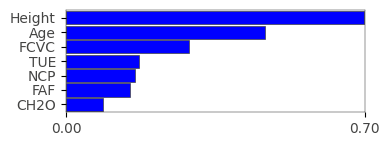

In [822]:
# creating a baseline model, this model and its performance will be used only for dataset cleaning purposes
rf,oob=evalReg(Xnum,y,150)
showimp(rf,Xnum,y)

Now, let's try to improve results by cleaning our dataset:
- handling missing values
- encoding non-numeric features

In [823]:
# first, let's separate numeric, non-numeric and target features.
Xnum=df.select_dtypes(include='number').drop('Weight',axis=1)
Xnonum=df.select_dtypes(exclude='number')
y=df['Weight']
# using function to replace missing values in numeric features with median values
fix_missing_num(Xnum)

In [824]:
# now let's handle missing values in non-numeric features
# --------------- normalizing missing values to NaN in non numeric features -----------------
missing_values_str=['unknown','??']
Xnonum=normalize_nonum(Xnonum,missing_values_str)
sniff(Xnonum)

,data type,percent missing,No. unique,unique values
Gender,object,5.352913,3,"[female, male, nan]"
family_history_with_overweight,object,5.826622,3,"[yes, no, nan]"
FAVC,object,5.400284,3,"[no, yes, nan]"
CAEC,object,5.495026,5,"[sometimes, frequently, always, nan, no]"
SMOKE,object,5.684510,3,"[no, yes, nan]"
SCC,object,5.352913,3,"[no, yes, nan]"
CALC,object,5.068688,5,"[no, sometimes, frequently, nan, always]"
MTRANS,object,0.000000,5,"[public_transportation, walking, automobile, m..."
NObeyesdad,object,5.400284,8,"[normal_weight, overweight_level_i, overweight..."


Mean OOB score: 0.9628065270600983
364,160 tree nodes and 22.5 median tree height


,Importance
Feature,
NObeyesdad,1.846562
Height,0.166166
Age,0.088120
Gender,0.014281
CH2O,0.012383
FCVC,0.008980
FAF,0.005866
TUE,0.004508
NCP,0.002998


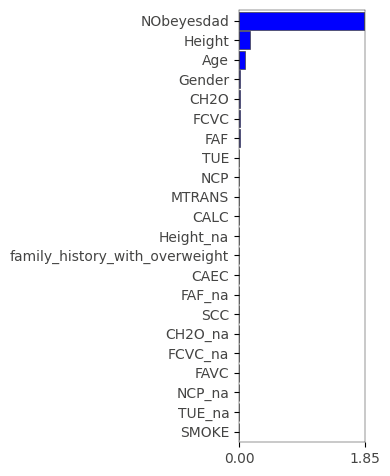

In [825]:
# now, for some features, we need to be sure they are properly ordinally encoded, according to dataset features description
encoder = ce.OrdinalEncoder(mapping=[{'col':'CAEC', 'mapping': {np.nan:0,'no':1, 'sometimes':2, 'frequently':3, 'always':4}},
                                     {'col':'CALC', 'mapping': {np.nan:0,'no':1, 'sometimes':2, 'frequently':3, 'always':4}},
                                     {'col':'NObeyesdad', 'mapping': {np.nan:0,'insufficient_weight':1, 'normal_weight':2, 'overweight_level_i':3, 'overweight_level_ii':4, 'obesity_type_i':5, 'obesity_type_ii':6, 'obesity_type_iii':7}}])
encoder.fit(Xnonum)
Xnonum=encoder.transform(Xnonum)
# all other features can be encoded with our functions
df_string_to_cat(Xnonum)
df_cat_to_catcode(Xnonum)

Xclean=pd.concat([Xnum,Xnonum],axis=1)
rf1,oob1=evalReg(Xclean,y,150)
showimp(rf1,Xclean,y)

It looks like `NObeyesdad` it's too closely related to target feature, then we decided to drop it. Additionally, by reading variables description, we found that some numeric features (`NCP, CH2O, FAF, and TUE`) having real numbers should be encoded as ordinal categories, so we'll convert them in to discrete values.

In [826]:
# I GUESS THERE'S A BETTER WAY TO DO CONVERSION FROM CONTINUOUS TO DISCRETE VALUES BUT I COULDN'T GET IT WORKING
Xnum1=Xnum.copy()
for x in Xnum1.NCP.index:
    if Xnum1.loc[x].NCP < 3:
        Xnum1.at[x,'NCP']=0
    else:
        if Xnum1.loc[x].NCP == 3:
            Xnum1.at[x,'NCP']=1
        else:
            if Xnum1.loc[x].NCP > 3:
                Xnum1.at[x,'NCP']=2

for x in Xnum1.CH2O.index:
    if Xnum1.loc[x].CH2O <= 1:
        Xnum1.at[x,'CH2O']=0
    else:
        if Xnum1.loc[x].CH2O > 2:
            Xnum1.at[x,'CH2O']=2
        else :
            Xnum1.at[x,'CH2O']=1
        
for x in Xnum1.FAF.index:
    if Xnum1.loc[x].FAF == 0:
        Xnum1.at[x,'FAF']=0
    else:
        if Xnum1.loc[x].FAF <= 2:
            Xnum1.at[x,'FAF']=1
        else:
            if Xnum1.loc[x].FAF <= 4:
                Xnum1.at[x,'FAF']=2
            else :
                Xnum1.at[x,'FAF']=3


Mean OOB score: 0.8222518142630735
376,616 tree nodes and 27.0 median tree height
Cleaning improved results in -14.59843788410997%
                                Importance
Feature                                   
Height                            0.362385
family_history_with_overweight    0.331193
FCVC                              0.289114
Age                               0.253307
Gender                            0.165259
CALC                              0.127219
TUE                               0.116164
NCP                               0.076272
CAEC                              0.075679
MTRANS                            0.022182
CH2O                              0.012908
Height_na                         0.011898
FAF                               0.010299
FAVC                              0.009439
FCVC_na                           0.006930
FAF_na                            0.004593
SCC                               0.004514
NCP_na                            0.003563
TUE_na   

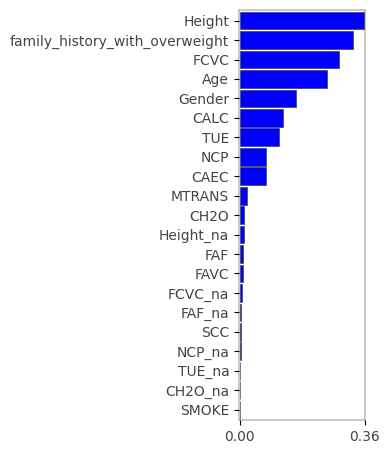

In [827]:

Xclean2=pd.concat([Xnum1,Xnonum],axis=1).drop('NObeyesdad',axis=1)
rf2,oob2=evalReg(Xclean2,y,150)
print(f'Cleaning improved results in {oob2*100/oob1-100}%')
I=showimp(rf2,Xclean2,y)
print(I)

Mean OOB score: 0.8261084890746041
376,712 tree nodes and 27.0 median tree height
Dropping features improved results in 0.46903816381203%


,Importance
Feature,
Height,0.388502
family_history_with_overweight,0.339655
FCVC,0.297951
Age,0.252425
Gender,0.151924
TUE,0.124138
CALC,0.114274
CAEC,0.081724
NCP,0.072528


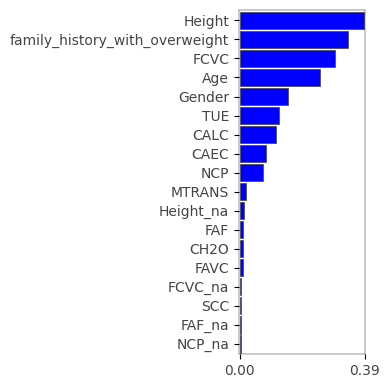

In [828]:
# Let's try to squeeze the maximum performance from dataset by dropping less important features
Xclean3=Xclean2.drop(I[I['Importance']<.003].index,axis=1)
rf3,oob3=evalReg(Xclean3,y,150)
print(f'Dropping features improved results in {(oob3*100/oob2)-100}%')
showimp(rf3,Xclean3,y)

For sure we didn't extensive testing be as far as we could observe, dropping a couple of features produced a slight improvement in performance so we'll consider data cleaning is done.

## Next step
Dataset is now cleaned and it looks good to be used to train, validate and test our models.The code related is in `reg_model_selection.ipynb`.

So now, before leaving this file, let's save dataset in to the table `reg_clean_data` in the database.

In [829]:
# puting features and target into a single dataframe to save it in database table
df_clean=pd.concat([Xclean3,y],axis=1)
df_clean.to_sql('reg_clean_data', con, if_exists='replace',index=False)
#just to confirm clean dataset was successfuly saved
print(pd.read_sql_query('select name from sqlite_master where type="table" and name like "%reg%"',con))
test=pd.read_sql_query('select * from reg_clean_data',con).sample(1)
test

             name
0    reg_raw_data
1  reg_clean_data


,Age,Height,FCVC,NCP,CH2O,FAF,TUE,Height_na,FCVC_na,NCP_na,FAF_na,Gender,family_history_with_overweight,FAVC,CAEC,SCC,CALC,MTRANS,Weight
222,21.0,1.72,3.0,2.0,2.0,0.0,2.0,0,0,0,0,1,2,2,4,1,1,4,66.5


In [830]:
con.commit()
con.close()